In [2]:
import sys
sys.path.append('..')


In [3]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'


In [4]:
from gax import sersic
from gax.sersic import sersic_2d_linear_pix
from matplotlib import pyplot as plt
import jax
import jax.numpy as jnp
import astropy
import numpy as np
from astropy.table import Table, vstack
import gax_fits as gfits
from astropy.io import fits
from scipy.interpolate import RegularGridInterpolator
from matplotlib.patches import Circle

bands = np.array(['u','g','r','i','z'])
wavs = np.array([354.3e-9, 477.0e-9, 623.1e-9, 762.5e-9, 913.4e-9], dtype=float)



In [16]:
# Now need a function for just diplaying the fit

def fit_overlay(Image,Table,R_min_multiple,m,objid=None):
    
    
    img = Image
    Tab = Table
    # First collect image info from Table
    x0 = np.array([img.shape[1]/2 + np.asarray(Tab['x'])]).astype(int) # x offset
    y0 = np.array([img.shape[0]/2 + np.asarray(Tab['y'])]).astype(int) # y offset
    R_e = 10**(np.asarray(Tab['log_re'])) # effective radius in pix
    log_R_e = np.asarray(Tab['log_re']) # log effective radius
    log_R_e_05 = np.log(10**np.asarray(Tab['log_re'])*R_min_multiple) # log half effective radius
    pa = np.asarray(Tab['theta']) # position angle
    q = np.asarray(Tab['q']) # axis ratio
    
    
    # Get the dimensions of the Image
    height, width = img.shape[:2]   

    # Calculate the maximum possible radius
    max_radius = min(x0, y0, width-x0, height-y0)
    max_R = max_radius -1
    
    # Create x and y index arrays
    y, x = np.indices(img.shape)
    
    # Center index arrays
    x -= x0
    y -= y0
    
    # Deprojecting x,y by a series of affine transformations

    # Rotate by minus position angle
    ct = np.cos(-pa)
    st = np.sin(-pa)

    # Stretch according to axis ratio and rotation
    xp = (y * ct + x * st) / q
    yp = (-y * st + x * ct)

    # Convert to Polar
    rp2 = xp ** 2 +  yp ** 2
    rp = np.sqrt(rp2)
    tp = np.arctan2(yp, xp)
    
    # Define ln(r),theta image dimensions
    n_lnr = 150
    n_theta = 150
    
    # Create index arrays
    lnr, theta = np.indices((n_lnr, n_theta))
    
    # Define bounds for image dimensions
    lnr_min = float(log_R_e_05)
    lnr_max = float(np.log(int(max_R) -1))
    theta_max = 360
    lnr = (lnr / n_lnr) * (lnr_max - lnr_min) + lnr_min
    theta = theta * theta_max / n_theta
    
    # Create yticks arrays
    lnr_y_axis = np.linspace(lnr_min,lnr_max,5)
    
    # Define xp and yp in terms of new coord system
    xp = np.exp(lnr) * np.sin(np.radians(theta))
    yp = np.exp(lnr) * np.cos(np.radians(theta))
    
    # this is an attempt at using the above deprojection code
    # to do the inverse by pa -> -pa and q -> 1/q   
    ct = np.cos(pa)
    st = np.sin(pa)
    x = (yp * ct + xp * st) * q
    y = (-yp * st + xp * ct)
    x += y0
    y += x0
    
    # Create a Regular grid from interpolation
    img_interp = RegularGridInterpolator((np.arange(img.shape[0]),
                                          np.arange(img.shape[1])), img)
    
    # Define allowed indices
    ok = (x >= 0) & (x < img.shape[0] - 1) 
    ok &= (y >= 0) & (y < img.shape[1] - 1) 
    
    # Create image from interpolation
    img_lnr_theta = img_interp((x, y))
    
    # Use broadcasting to do multiple p at once
    p = np.arange(-25, 25, 0.1).reshape((-1, 1, 1))
    weight = np.exp(1j*(m * np.radians(theta) + lnr * p))
    D = img_lnr_theta.sum()
    A = 1/D * abs((img_lnr_theta * weight).sum((-1, -2)))
    A_p_m = 1/D *(img_lnr_theta * weight).sum((-1, -2))
    
    # Calculate winding angle from maximum of Spiral Power spectrum
    p_max = p.ravel()[A.argmax()]
    phi = np.degrees(np.arctan(-m/p_max))#
    
    # Generate spiral for plotting
    x_,y_, argument = gfits.gen_spiral(p_max,A_p_m,m,R_e,R_min_multiple,img,x0[0],y0[0])
    
    if 88<phi<92 or -88>phi>-92:
        print('Winding angle \u03C6 =',None,'- No pattern identified')
    else:
        print('Winding angle \u03C6 =', phi,' Pattern position angle \u03B8 = ',np.degrees(argument))
        
    
    
    # Calculate signal to Noise
    SN_m, SN_w = gfits.SN(A_p_m)

    # Labeled galaxy Image
    fig, ax = plt.subplots()
    ax.imshow(img,vmin=np.mean(img)-2*np.std(img),vmax=np.mean(img)+2*np.std(img))

    # Define circle
    R_e_1 = Circle((x0,y0),R_e,edgecolor='black', facecolor=None, fill=False)
    R_e_05 = Circle((x0,y0),R_min_multiple*R_e,edgecolor='red', facecolor=None, fill=False)
    
    ax.plot(x0,y0,'xk')
    ax.plot(x_,y_,'r-')
    print("Objid=",objid)
    fig.suptitle('Spiral overlay on {}'.format(objid))
    
    ax.add_patch(R_e_1)
    ax.add_patch(R_e_05)
    ax.legend(['center','Spiral Fit','$R_e$','${}\, R_e$'.format(R_min_multiple)])
    ax.axis('off')
    

In [17]:
def r_min_diagnosis(OBJID,parent_dir):
    table, image = gfits.Composite_from_directory_raid(OBJID,parent_dir)

    # create an array of multiples from 0.3-1.5?

    R_e_multiples = np.arange(0.3,1.51,0.2)

    # Get center and R_e out of the table

    R_e = np.asarray(10**table['log_re'])
    x0 = np.asarray(table['x']) + image.shape[1]/2
    y0 = np.asarray(table['y']) + image.shape[0]/2


    # Begin plotting

    colours =  plt.cm.hsv(np.linspace(0,1,len(R_e_multiples)))

    fig, ax = plt.subplots(1,5,figsize=(25, 25))
   
    for i in range(0,len(bands)):
        ax[i].imshow(image[:,:,i],vmin=np.mean(image[:,:,i])-7.5*np.std(image[:,:,i]),vmax=np.mean(image[:,:,i])+7.5*np.std(image[:,:,i]))
        if i == 0:
            ax[i].set_title('{} {}'.format(OBJID,bands[i]))
        else:
            ax[i].set_title('{}'.format(bands[i]))
        ax[i].axis('off')
        for j in range(0,len(R_e_multiples)):
            loop_patch = Circle((x0[i],y0[i]),R_e_multiples[j]*R_e[i],color=colours[j], facecolor=None, fill=False)
            ax[i].add_patch(loop_patch)
        ax[i].legend(['{}'.format(R_e_multiples[0]),'{}'.format(R_e_multiples[1]),'{}'.format(R_e_multiples[2]),'{}'.format(np.around(R_e_multiples[3]),1),'{}'.format(R_e_multiples[4]),'{}'.format(R_e_multiples[5]),'1.5'])

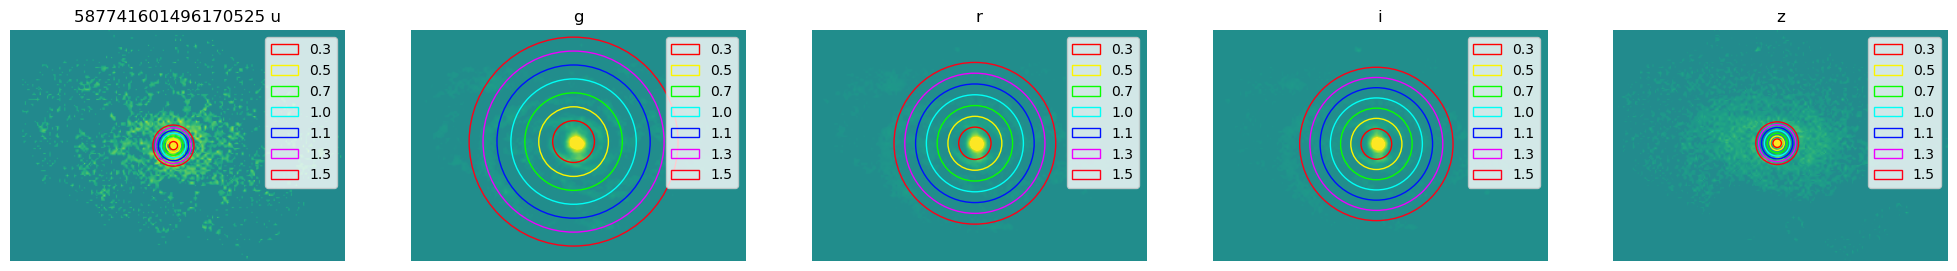

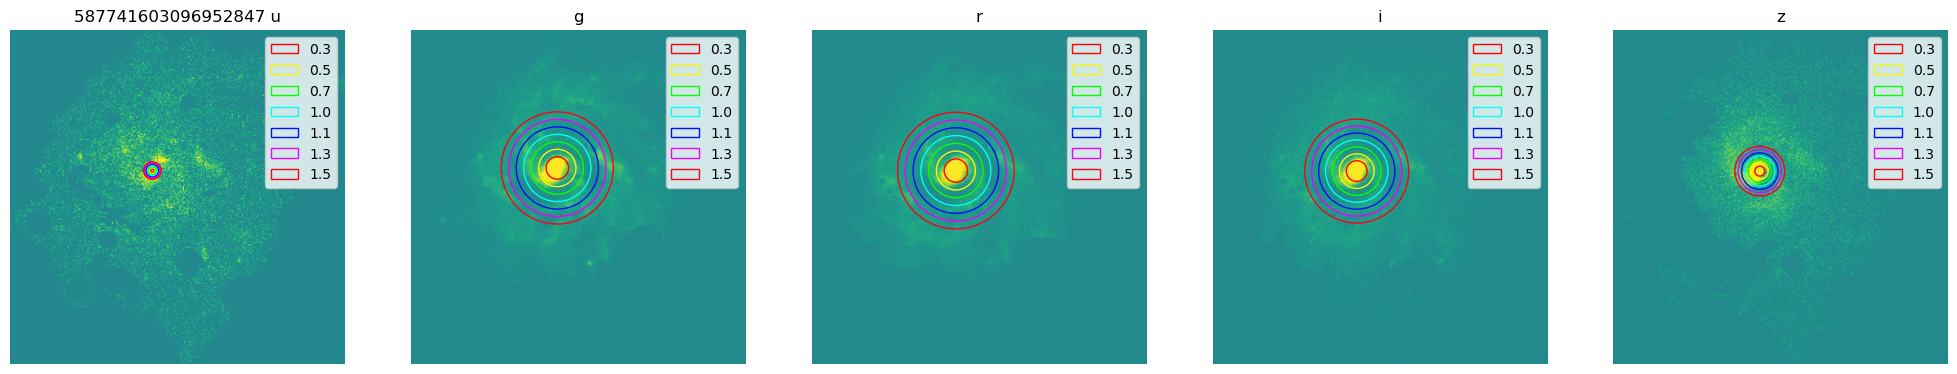

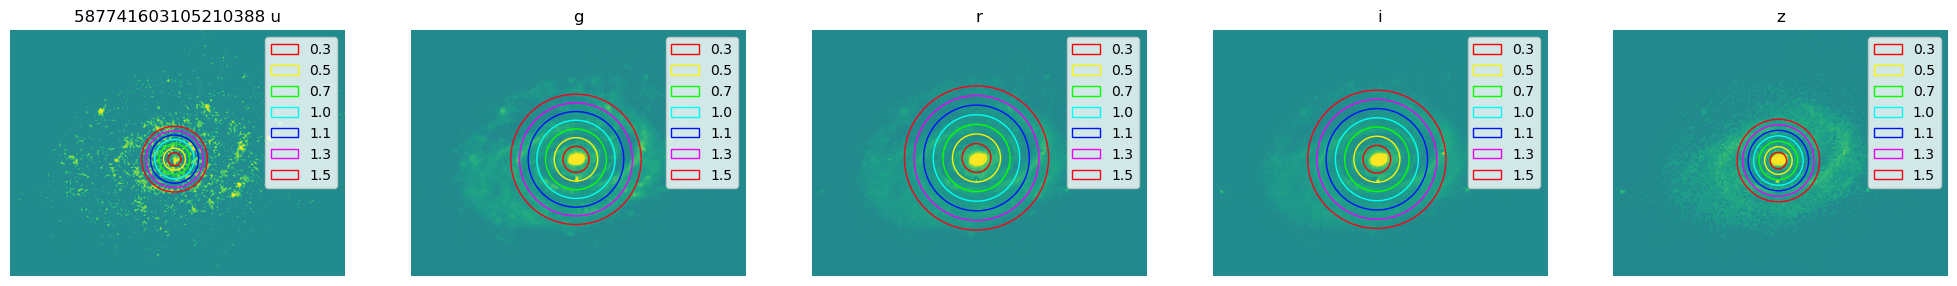

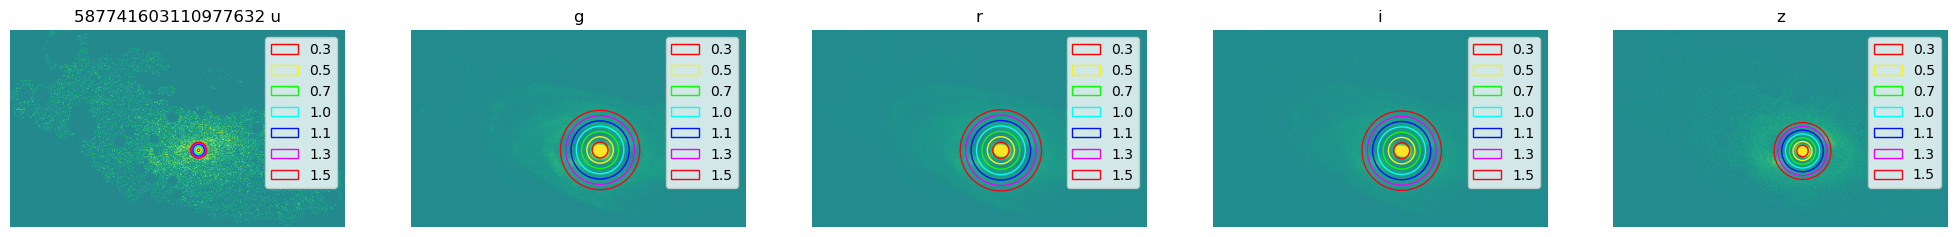

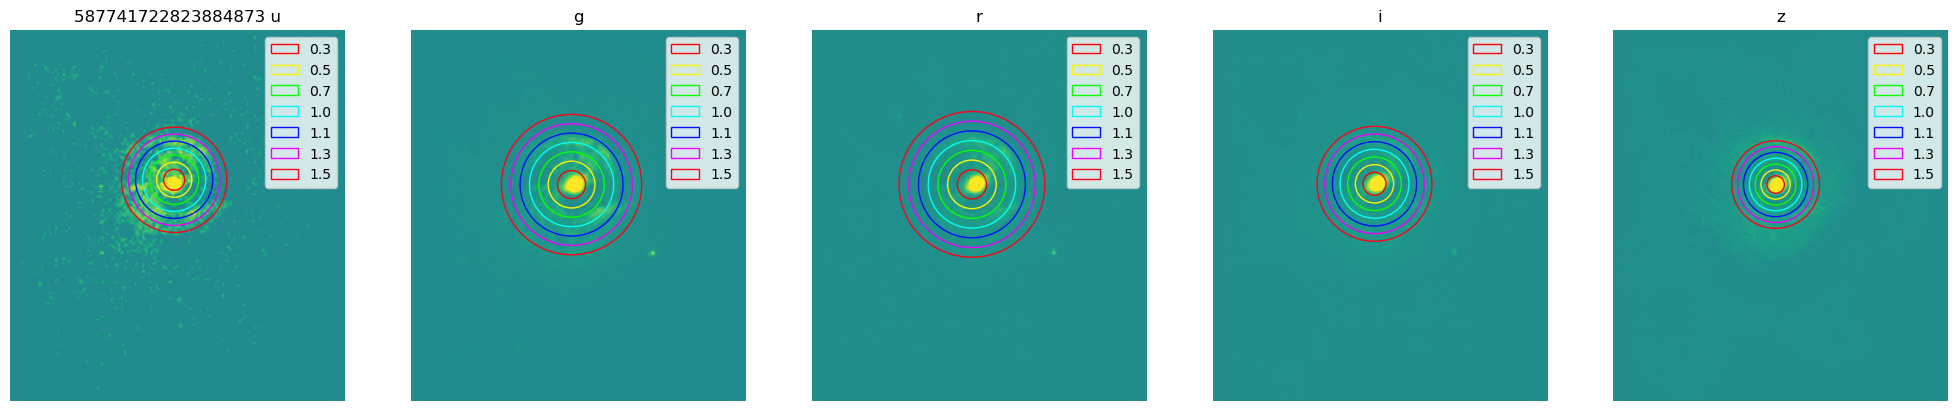

In [18]:
# This is a demonstration of running the diagnosis tool for three candidates

# Take your portion of the candidates and put it into candidate_list


candidate_list = np.array(['587741601496170525','587741603096952847','587741603105210388','587741603110977632','587741722823884873'])
parent_dir = '/home/borge/Data/MLIS1_Output/01_04_23/Output_01_04_23/'

for i in range(0,len(candidate_list)):
    r_min_diagnosis(candidate_list[i],parent_dir)


In [19]:
# Take your estimates of which ring contains the region we want to exclude - bar bulge etc

# Input you estimates into the google sheets - the candidate number is the 18 digit identifier 
# included in the title of the u band image ( dont do ths one )

# You can check your estimates below using the SFT function and inputting into the section R_min_multiple your guess 
# obviously you will have to feed it the candidate image and table as well - if further explanation is required see the gax
# fits documentation for the function you are using - everything you need is in there

# If you are really unsure of m you can run number of arms with your guess for the exclude region



(312, 424, 5)
Winding angle φ = 27.758540601061895  Pattern position angle θ =  9.331133673053374
Objid= 587741603105210388


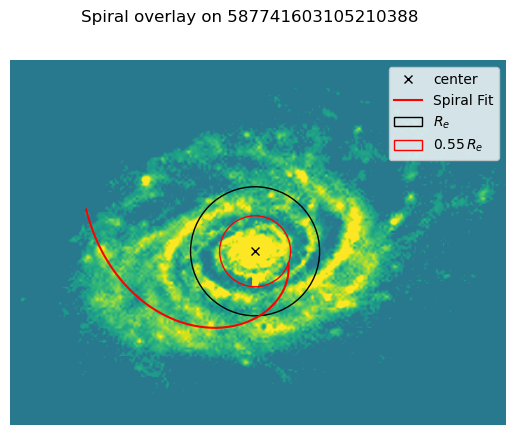

In [71]:
parent_dir = '/home/borge/Data/MLIS1_Output/01_04_23/Output_01_04_23/' # your location where the ficl outputs are held
OBJID = '587741603105210388'
table, composite_image = gfits.Composite_from_directory_raid(OBJID, parent_dir)
R_min_multiple = 0.55
band = 1
print(composite_image.shape)
m = gfits.Number_of_arms(composite_image[:,:,band],table[band],R_min_multiple,False,False,objid=OBJID)
fit_overlay(composite_image[:,:,band],table[band],R_min_multiple,m,objid=OBJID)

# Getting this right requires a little trial and error the first preliminary diagnosis may not always give a good fit 
# make sure using this section that your fit is actually meaningfull

In [72]:
# Function for easier diagnosis

def diagnose(OBJID,parent_dir,R_min_multiple):
    
    table, composite_image = gfits.Composite_from_directory_raid(OBJID, parent_dir)
    
    band = np.array([1,2,3,4])
    print(composite_image.shape)
    for i in range(0,len(bands)):
        m = gfits.Number_of_arms(composite_image[:,:,band[0]],table[band[0]],R_min_multiple[0],False,False,objid=OBJID)
        fit_overlay(composite_image[:,:,band[i]],table[band[i]],R_min_multiple[i],m,objid=OBJID)

(312, 424, 5)
Winding angle φ = 27.14968169778496  Pattern position angle θ =  6.699396821436744
Objid= 587741603105210388
Winding angle φ = 29.744881296944378  Pattern position angle θ =  8.904683359950857
Objid= 587741603105210388
Winding angle φ = 29.0546040990792  Pattern position angle θ =  -5.027342315375067
Objid= 587741603105210388


IndexError: index 3 is out of bounds for axis 0 with size 3

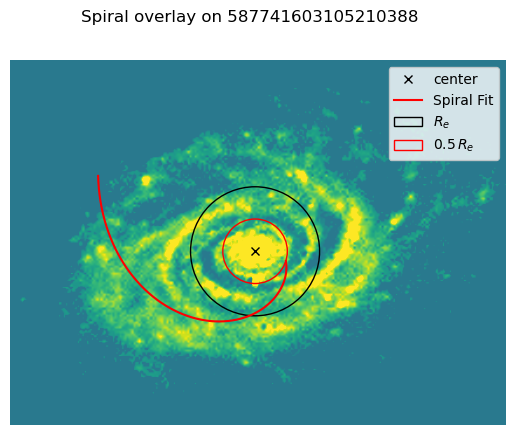

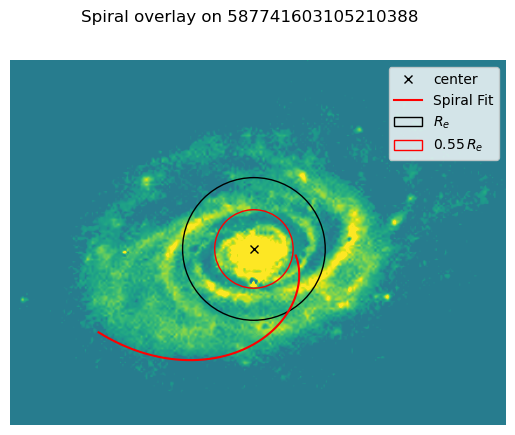

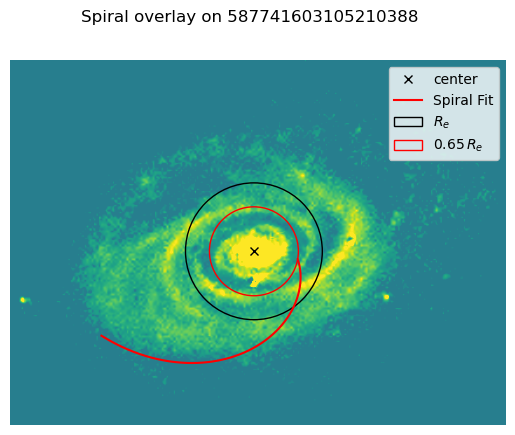

In [78]:
parent_dir = '/home/borge/Data/MLIS1_Output/01_04_23/Output_01_04_23/' # your location where the ficl outputs are held
OBJID = '587741603105210388'
R_min_multiple = np.array([0.5,0.55,0.65])

diagnose(OBJID,parent_dir,R_min_multiple)